# Tutorial on Global Temperature Trends with Deep Learning 

## Predicting global temperature from greenhouse gas concentrations

Here we will look at an example of using a neural network to predict the global temperature given the global atmospheric concentrations of CO2 and CH4. This is based on this [notebook](https://github.com/leap-stc/LEAP-bootcamps/blob/main/Codes/Day2/Neural_Network_example.ipynb) developed by Weiwei Zhan.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

2025-07-31 03:17:35.012850: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-31 03:17:35.024875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-31 03:17:35.039895: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-31 03:17:35.044828: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-31 03:17:35.056159: I tensorflow/core/platform/cpu_feature_guar

In [2]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

## Visualization of the ClimateBench Data 

ClimateBench is a spatial-temporal dataset that contains simulations generated by the NorESM2 climate model. It provides both historical simulations & future projections under different scenarios (e.g., ssp245).

Four future scenarios are plotted here: ssp126, ssp245, ssp370, ssp585. These scenarios make different assumptions about future anthropogenic emissions.

In [3]:
def open_dataset(file_path):
    """Flexible opener that can handle both local files (legacy) and cloud urls. IMPORTANT: For this to work the `file_path` must be provided without extension."""
    if 'gs://' in file_path:
        store = f"{file_path}.zarr"
        ds = xr.open_dataset(store, engine='zarr')
    else:
        ds = xr.open_dataset(f"{file_path}.nc")
        # add information to sort and label etc
        ds.attrs['file_name']
    return ds

In [4]:
scenarios = ['historical','ssp126','ssp370','ssp585']
inputs = [os.path.join(train_path , f"inputs_{scenario}") for scenario in scenarios]
inputs.append(os.path.join(test_path, "inputs_ssp245"))
inputs.sort(key=lambda x:x.split('_')[-1])

outputs = [os.path.join(train_path , f"outputs_{scenario}") for scenario in scenarios]
outputs.append(os.path.join(test_path, "outputs_ssp245"))
outputs.sort(key=lambda x:x.split('_')[-1])

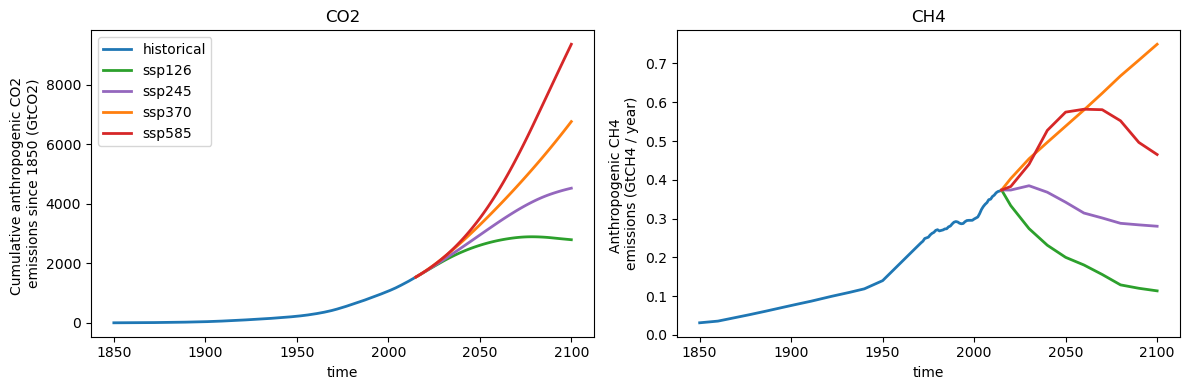

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
colors  = ['tab:blue','tab:green','tab:purple','tab:orange','tab:red']


for i,input in enumerate(inputs):

    label=input.split('_')[-1]#[:-3]
    X = open_dataset(input)
    x = X.time.data
    
    X['CO2'].plot(label=label,color=colors[i],linewidth=2,ax=axes[0])

    axes[0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
    
    X['CH4'].plot(label=label,color=colors[i],linewidth=2,ax=axes[1])

    axes[1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
    
axes[0].set_title('CO2')
axes[1].set_title('CH4')
axes[0].legend()
plt.tight_layout()

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(9,4))

for i,output in enumerate(outputs):

    label=output.split('_')[-1]#[:-3]
    X = open_dataset(output).mean(dim="member")[['tas']].drop_vars(['quantile'])
    x = X.time.data
    
    weights  = np.cos(np.deg2rad(X.lat))
    tas_mean = X['tas'].weighted(weights).mean(['lat', 'lon']).data
    tas_std  = X['tas'].weighted(weights).std(['lat', 'lon']).data
    
    ax.plot(x, tas_mean, label=label,color=colors[i],linewidth=2)
    ax.fill_between(x,tas_mean+tas_std,tas_mean-tas_std,facecolor=colors[i],alpha=0.2)
    
ax.set_ylabel("Global average temperature\n since 1850 (°C)")
ax.legend()
plt.tight_layout()

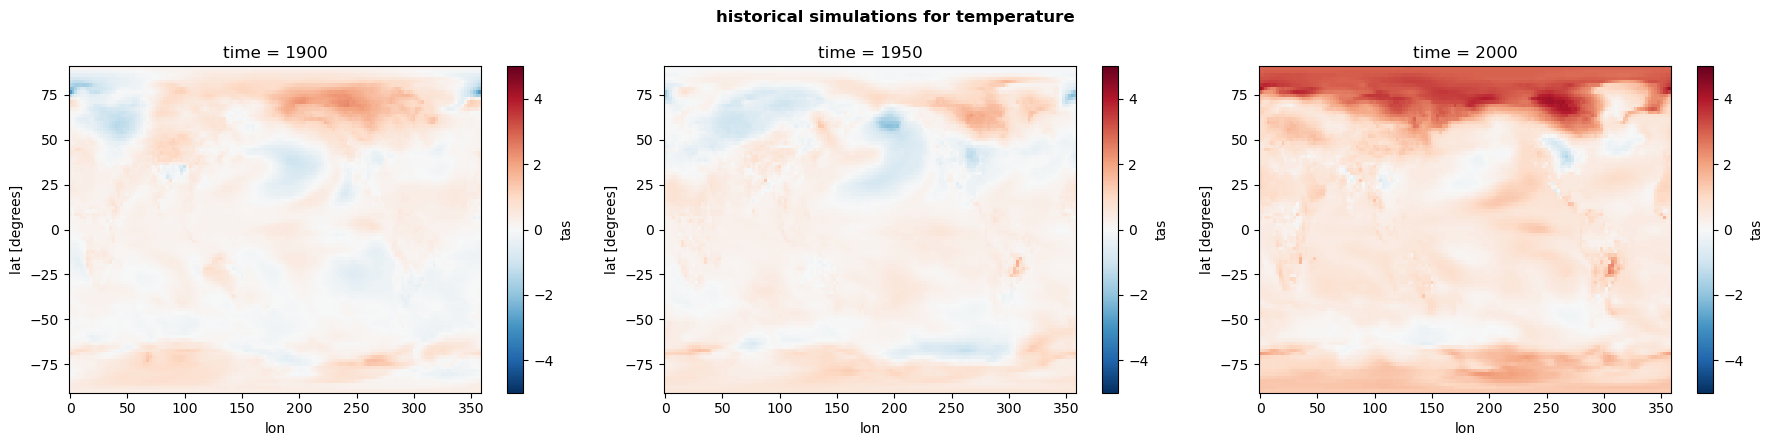

In [7]:
y_his    = open_dataset(os.path.join(train_path , "outputs_historical")).mean(dim="member")[['tas']].drop_vars(['quantile'])
y_ssp370 = open_dataset(os.path.join(train_path,'outputs_ssp370')).mean(dim="member")[['tas']].drop_vars(['quantile'])

fig,axes = plt.subplots(figsize=(18,4.5),ncols=3)
yr0, yr1, yr2 = 1900, 1950, 2000
vmin, vmax = -5, 5

y_his.sel(time=yr0).tas.plot(ax=axes.flat[0],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y_his.sel(time=yr1).tas.plot(ax=axes.flat[1],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y_his.sel(time=yr2).tas.plot(ax=axes.flat[2],vmin=vmin,vmax=vmax,cmap='RdBu_r')

fig.suptitle('historical simulations for temperature',fontweight='bold')
plt.tight_layout()

In [8]:
y_ssp370 = open_dataset(os.path.join(train_path,'outputs_ssp370')).mean(dim="member")[['tas']].drop_vars(['quantile'])


fig,axes = plt.subplots(figsize=(18,4.5),ncols=3)
yr0, yr1, yr2 = 2020, 2050, 2100
vmin, vmax = -5, 5

y_ssp370.sel(time=yr0).tas.plot(ax=axes.flat[0],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y_ssp370.sel(time=yr1).tas.plot(ax=axes.flat[1],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y_ssp370.sel(time=yr2).tas.plot(ax=axes.flat[2],vmin=vmin,vmax=vmax,cmap='RdBu_r')

fig.suptitle('future simulations (ssp370) for temperature',fontweight='bold')
plt.tight_layout()

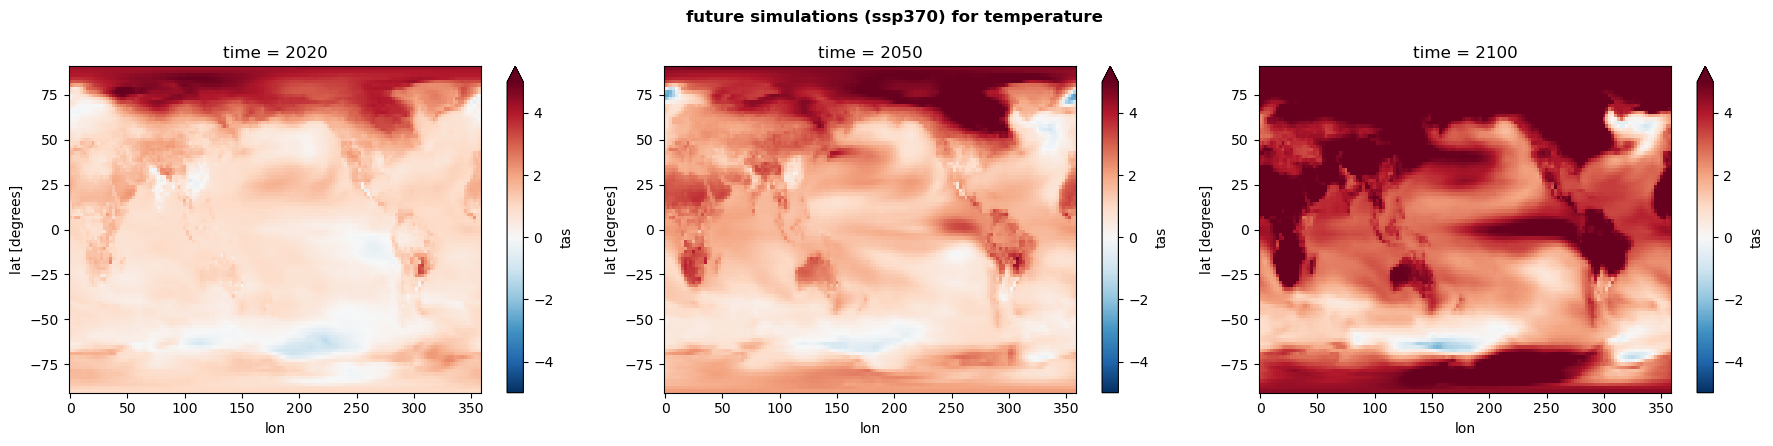

In [9]:
y_ssp370 = open_dataset(os.path.join(train_path,'outputs_ssp370')).mean(dim="member")[['tas']].drop_vars(['quantile'])


fig,axes = plt.subplots(figsize=(18,4.5),ncols=3)
yr0, yr1, yr2 = 2020, 2050, 2100
vmin, vmax = -5, 5

y_ssp370.sel(time=yr0).tas.plot(ax=axes.flat[0],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y_ssp370.sel(time=yr1).tas.plot(ax=axes.flat[1],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y_ssp370.sel(time=yr2).tas.plot(ax=axes.flat[2],vmin=vmin,vmax=vmax,cmap='RdBu_r')

fig.suptitle('future simulations (ssp370) for temperature',fontweight='bold')
plt.tight_layout()

## Data preprocessing
We will train the NN using simulations from 3 historical and 3 future scenarios. We will then test the trained NN on the ssp245 scenario. 

In [10]:
def prepare_predictor(data_sets, data_path,time_reindex=True):
    """
    Args:
        data_sets list(str): names of datasets
    """
        
    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]
        
    X_all      = []
    length_all = []
    
    for file in data_sets:
        data = open_dataset(f"{data_path}inputs_{file}")
        X_all.append(data)
        length_all.append(len(data.time))
    
    X = xr.concat(X_all,dim='time')
    length_all = np.array(length_all)

    if time_reindex:
        X = X.assign_coords(time=np.arange(len(X.time)))

    return X, length_all
def prepare_predictand(data_sets,data_path,time_reindex=True):
    if isinstance(data_sets, str):
        data_sets = [data_sets]
        
    Y_all = []
    length_all = []
    
    for file in data_sets:
        data = open_dataset(f"{data_path}outputs_{file}")
        Y_all.append(data)
        length_all.append(len(data.time))
    
    length_all = np.array(length_all)
    Y = xr.concat(Y_all,dim='time').mean('member')
    Y = Y.rename({'lon':'longitude','lat': 'latitude'}).transpose('time','latitude', 'longitude').drop_vars(['quantile'])
    if time_reindex:
        Y = Y.assign_coords(time=np.arange(len(Y.time)))
    
    return Y, length_all

In [11]:
# Training set
train_files    = ["historical", "ssp585", "ssp126", "ssp370","hist-aer","hist-GHG"]
X_train_xr, _  = prepare_predictor(train_files,train_path)
y_train_xr, _  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

In [12]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)

In [13]:
y_train_df = y_train_xr["tas"].stack(z=("latitude", "longitude"))
y_train_df = pd.DataFrame(y_train_df.to_pandas())

In [14]:
X_train_df.head()

CO2       CH4
0  0.188297  0.031306
1  0.377244  0.031742
2  0.573814  0.032178
3  0.778848  0.032614
4  1.020320  0.033049

In [15]:
print(len(y_train_df))
y_train_df.head()

753


latitude      -90.0                                                    \
longitude     0.0       2.5       5.0       7.5       10.0      12.5    
time                                                                    
0          0.320023  0.319946  0.319865  0.319885  0.319860  0.319865   
1         -0.667297 -0.667023 -0.667114 -0.667109 -0.667109 -0.667135   
2         -0.058345 -0.058167 -0.058248 -0.058243 -0.058248 -0.058248   
3          0.125870  0.125941  0.125946  0.125941  0.125946  0.125890   
4          0.418304  0.418533  0.418503  0.418523  0.418477  0.418513   

latitude                                           ...      90.0            \
longitude     15.0      17.5      20.0      22.5   ...     335.0     337.5   
time                                               ...                       
0          0.319870  0.319911  0.319763  0.319707  ...  0.913116  0.913289   
1         -0.667114 -0.667104 -0.667104 -0.666992  ...  0.042501  0.042679   
2         -0.058233 -0.058207 -0.058345 -0.058177  ...  1.167440  1.167389   
3          0.125951  0.125941  0.125895  0.125982  ... -0.339457 -0.339589   
4          0.418503  0.418549  0.418482  0.418564  ...  0.577006  0.576996   

latitude                                                               \
longitude     340.0     342.5     345.0     347.5     350.0     352.5   
time                                                                    
0          0.913116  0.912933  0.912893  0.912659  0.912384  0.912181   
1          0.049225  0.055695  0.055506  0.055227  0.054789  0.054230   
2          1.169657  1.172119  1.172201  1.172190  1.172292  1.172424   
3         -0.332387 -0.324961 -0.324956 -0.325038 -0.325063 -0.325033   
4          0.585297  0.593811  0.593740  0.593719  0.593648  0.593801   

latitude                       
longitude     355.0     357.5  
time                           
0          0.911825  0.911611  
1          0.053604  0.052897  
2          1.172709  1.173228  
3         -0.325022 -0.324880  
4          0.593760  0.593943  

[5 rows x 13824 columns]

## Data normalization

In [16]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,y_train.shape)

(753, 2) (753, 13824)


## Define the neural network structure

Here we will use a neural network that has 3 hidden layers, and each hidden layer has 64 neurons. The input to the neural network will be the CO2 and CH4 concentrations at each time step. 

The neural network outputs are the global surface temperatures (tas), with each neuron of the output layer corresponding to each pixel. There are 13824 pixels in total (96 latitude and 144 longitude).

In [21]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1
N_layers       = 3 # number of hidden layers

In [22]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu",name="hidden_layer_1"),
    tf.keras.layers.Dense(64, activation="relu",name="hidden_layer_2"),
    tf.keras.layers.Dense(64, activation="relu",name="hidden_layer_3"),
    tf.keras.layers.Dense(y_train.shape[1],activation='linear',name="output_layer")
])

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 13824)          │       898,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 907,072 (3.46 MB)

 Trainable params: 907,072 (3.46 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

## Train the Neural Network and Save its weights

In [25]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.6975 - val_loss: 0.5645
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.4389 - val_loss: 0.5310
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.1838 - val_loss: 0.4637
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.1779 - val_loss: 0.3538
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.2680 - val_loss: 0.2612
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.7942 - val_loss: 0.2684
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.4888 - val_loss: 0.2960
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.4326 - val_loss: 0.2808
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.3985 - val_loss: 0.2794
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.3903 - val_loss: 0.2711
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3935 - val_loss: 0.2738
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.3

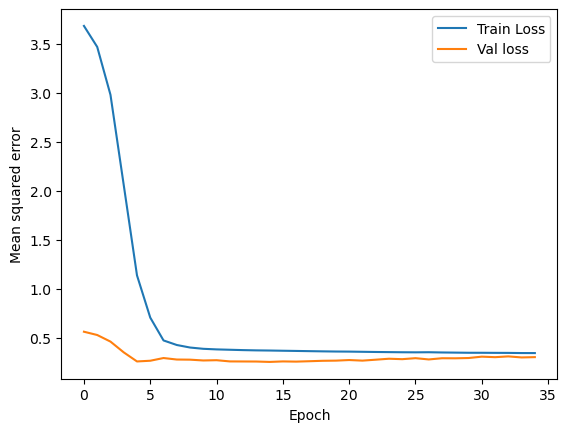

In [26]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Val loss')
plt.legend()

In [27]:
model_path = os.path.join(cwd,'saved_model')
if os.path.exists(model_path) is False:
    os.makedirs(model_path)

In [28]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'NN_model.keras'))

## Evaluate the trained model

We will evaluate the trained neural network on the test data set by comparing the neural network predictions against the original surface temperatures simulated under the ssp245 scenario.

In [29]:
# reload the saved model
model = load_model(os.path.join(model_path,'NN_model.keras'))

In [30]:
y_test_pre = model.predict(X_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)

y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


First we check whether the ML model can capture the spatial distribution of global temperatures.

In [31]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

Then we will also check how well the ML model can reproduce the time series of a given location. Here we will take NYC as an example (40.7128° N, 74.0060° W)

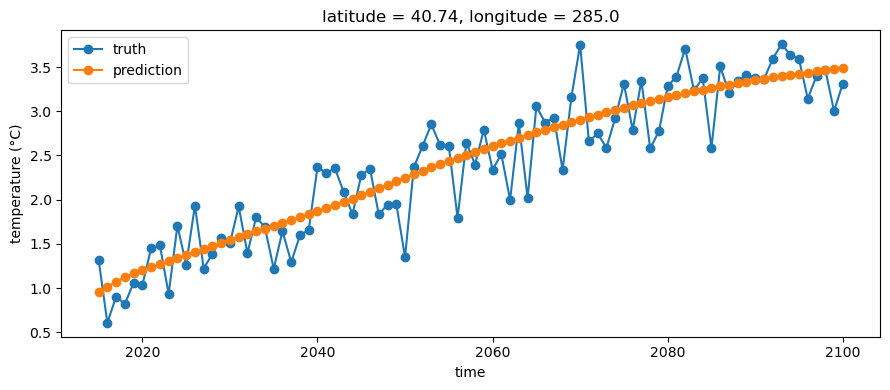

In [32]:
lat = 40.7128
lon = -74.0060%360

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='truth')
y_test_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='prediction')

ax.legend()
ax.set_ylabel('temperature (°C)')

plt.tight_layout()

Finally, we will check whether the ML model can capture the time series of global average temperature

In [33]:
def global_mean_std_plot(X,label,color,ax,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    tas_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, tas_mean, label=label,color=color,linewidth=2)
    ax.fill_between(x,tas_mean+tas_std,tas_mean-tas_std,facecolor=color,alpha=0.2)

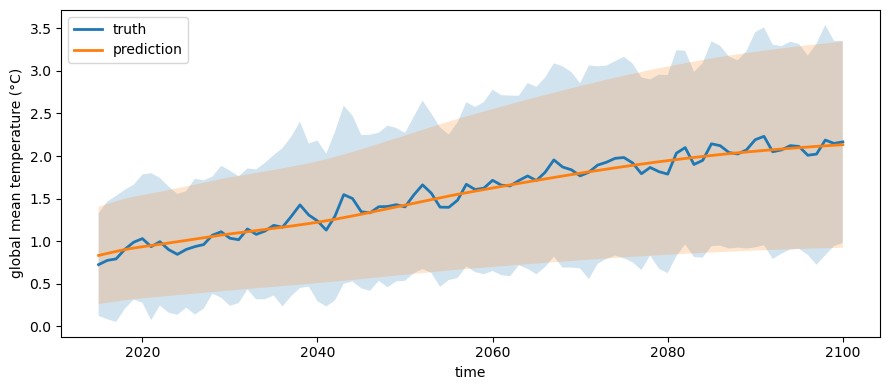

In [34]:
fig,ax = plt.subplots(figsize=(9,4))

global_mean_std_plot(y_test_xr,label='truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_pre,label='prediction',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('global mean temperature (°C)')
ax.legend()
plt.tight_layout()

## Train a CNN to predict the global temperature map
Next, we will look at using a CNN rather than a NN to predict the global temperature map. This example is based on the [notebook](https://github.com/leap-stc/LEAP-bootcamps/blob/main/Codes/Day2/CNN_example.ipynb) by Weiwei Zhan and Francesco Immorlano.

We start with preparing the datasets as before.

In [35]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)

y_train = y_train_xr['tas'].data
y_test  = y_test_xr['tas'].data

For the CNN, the predictant (target) will be a 2-D map of global temperature, rather than a 1-D array (as it was for the NN)

## Data Normalization

Let's normalize the input predictors by their mean and standard deviation.

In [36]:
	# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

In [37]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(753, 2) (753, 96, 144) (86, 2) (86, 96, 144)


## Define the CNN architecture

The CNN architecture used here consists of several upsampling blocks. 

We set the dimensions of the hidden layers (i.e., number of neurons) in order to reach the size of the target maps (96x144) in a proportional way (in particular by doubling the dimensions in each upsampling block) through the various upsampling blocks.

Here are the hyperparameters for the CNN training. Note that these hyperparameters here are for demonstration purposes only and they are not optimized.

In [38]:
n_filters  = 32  # number of filters
n_neurons  = 32  # number of neurons in the Dense layer
activation     = 'relu' # activation function
kernel_size    = 4
learning_rate  = 0.001
minibatch_size = 64
num_epochs     = 100

In [39]:
model = Sequential()


model.add(Input(shape=(X_train.shape[1],))),
model.add(Dense(n_filters*12*18, input_shape=(X_train.shape[1],), activation=activation)) # shape: (6912,1)
model.add(Reshape((12,18,n_filters))) # shape: (12,18,32)

# Upsample to 24x36
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (24,36,32)

# Upsample to 48x72
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (48,72,32)

# Upsample to 96x144
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (96,144,32)

model.add(Conv2DTranspose(filters=1, kernel_size=kernel_size, activation="linear", padding="same")) # shape: (96,144,1)


model.summary()
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

/srv/conda/envs/notebook/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6912)           │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 12, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 24, 36, 32)     │        16,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 48, 72, 32)     │        16,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 96, 144, 32)    │        16,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 96, 144, 1)     │           513 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,497 (275.38 KB)

 Trainable params: 70,497 (275.38 KB)

 Non-trainable params: 0 (0.00 B)

## Train and save the CNN model

In [40]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history_cnn = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 3.7040 - val_loss: 0.4203
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 2.4507 - val_loss: 0.4251
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 1.4679 - val_loss: 0.2405
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.8678 - val_loss: 0.2778
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.7540 - val_loss: 0.2717
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.6219 - val_loss: 0.2596
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.5837 - val_loss: 0.2516
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.5377 - val_loss: 0.2496
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.5442 - val_loss: 0.2529
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.5319 - val_loss: 0.2565
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.5203 - val_loss: 0.2510
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.4

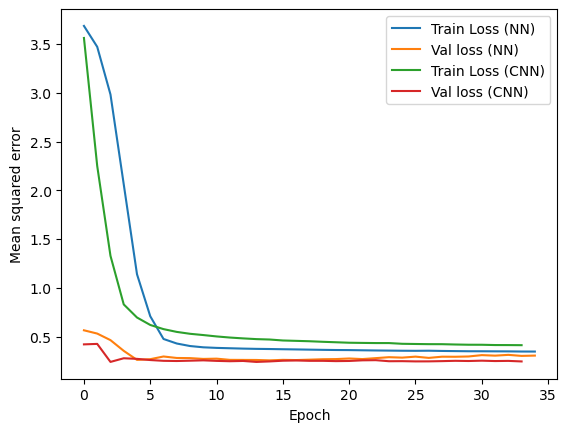

In [41]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Train Loss (NN)')
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Val loss (NN)')
plt.plot(history_cnn.epoch, np.array(history_cnn.history['loss']),label='Train Loss (CNN)')
plt.plot(history_cnn.epoch, np.array(history_cnn.history['val_loss']),label = 'Val loss (CNN)')
plt.legend()

In [42]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'CNN_model.keras'))

## Evaluate the trained model

We will load the model since it takes a while to train.

In [39]:
# reload the saved model
model = load_model(os.path.join(model_path,'CNN_model.keras'))

In [44]:
y_test_pre = model.predict(X_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)
y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step


First we check whether the ML model can capture the spatial distribution of global temperature

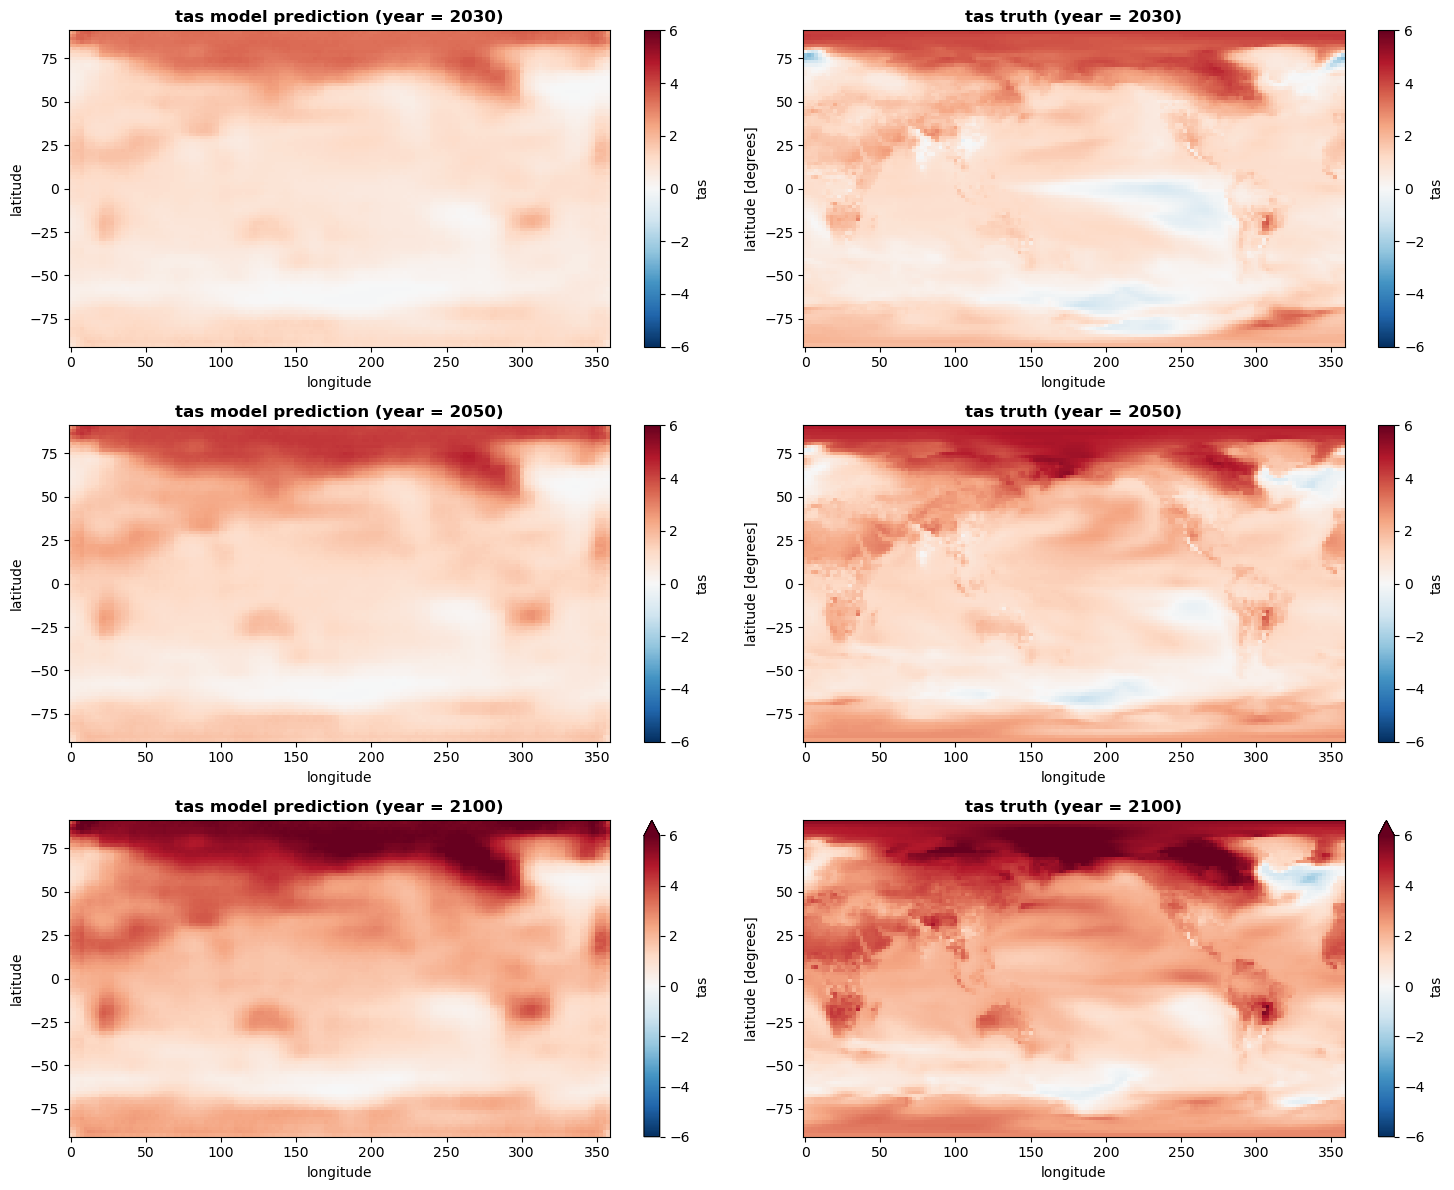

In [42]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

Then we also check whether the ML model can reproduce the time series of a given location.
Here we take NYC as an example (40.7128° N, 74.0060° W)

Text(0, 0.5, 'temperature (°C)')

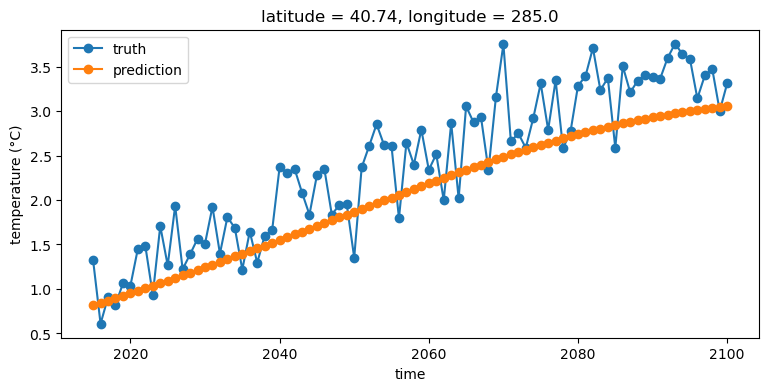

In [44]:
lat = 40.7128
lon = -74.0060%360

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='truth')
y_test_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='prediction')

ax.legend()
ax.set_ylabel('temperature (°C)')

Finally we will check whether the ML model can capture the time series of global average temperatures. 

In [47]:
def global_mean_std_plot(X,label,color,ax,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    tas_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, tas_mean, label=label,color=color,linewidth=2)
    ax.fill_between(x,tas_mean+tas_std,tas_mean-tas_std,facecolor=color,alpha=0.2)

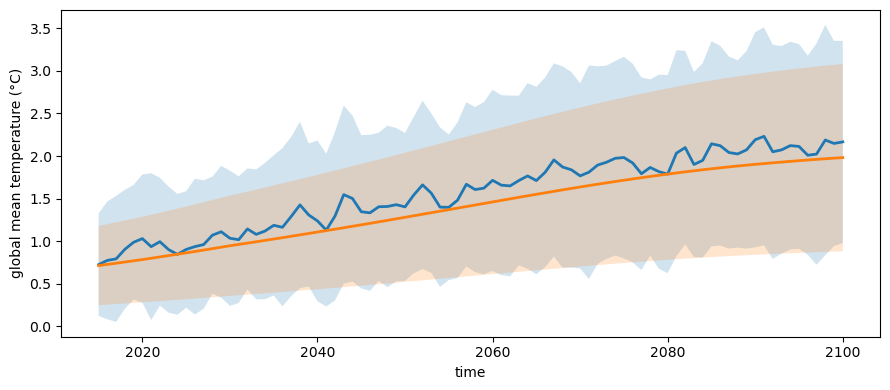

In [48]:
fig,ax = plt.subplots(figsize=(9,4))

global_mean_std_plot(y_test_xr,label='truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_pre,label='prediction',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('global mean temperature (°C)')
plt.tight_layout()